# Chapter 4: LMS-Based Algorithms

## Imports 

In [1]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import SignError, LMSNewton
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Problem 8

x(k) is obtained after passing n(k) through the following filter 

$$H_{in}(z) = \frac{X(z)}{N(z)} = \frac{1}{1-0.9z^{-1}}$$

Consequently

$$x(k) = 0.9x(k-1)+n(k)$$

According to Equation (2.83)

$$r(l) = \frac{(0.9)^{|l|}}{1-(-0.9)^2}\sigma_{n_x}^2$$

For $N+1$ = 12 coefficients, $tr[R] = (N+1)r(0) = 31.578$. For the sign-error algorithm, the condition that guarantees both convergence and low-variance in the steady-state is given by 
	
$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} \sqrt{\frac{\pi \xi (k)}{2}} $$

By considering $\xi(k) = \xi_{min} = \sigma_n^2$ (Most strict scenario for $\mu$ considering the minimum measurement error) we have 

$$ 0 < \mu < 0.0182 $$


In [2]:
output_filepath = './Outputs/Chap_4/Exercise_23/'
model_name = 'NLMS'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))*(np.sqrt(np.pi*mse_min_estimate/2))
print ('mu_max: ', mu_max)

Trace: 31.57894736842106
mu_max:  0.0012550536442419034


### (b)

$$ H(z) = \frac{D(z)}{X(z)} = \frac{1-z^{-12}}{1+z^{-1}} $$

$$ d(k) = -d(k-1)+x(k)-x(k-12)  $$

In [3]:
K = 10000 # number of iterations (signal length)
factor = 10
mu = mu_max/factor

def G(x): # Input signal filter before unknown system
        y = np.zeros(len(x), dtype = complex)
        for ii in range(len(x)):
            y[ii] = .9*y[ii-1] + x[ii]
        return y
    
def H(x): # Unknown system 
    postfixed_x = np.append(x,np.zeros(12,dtype = complex))
    postfixed_y = np.zeros(len(postfixed_x), dtype = complex)
    for ii in range(0,len(postfixed_x)):
        postfixed_y[ii] = (-1)*postfixed_y[ii-1] + postfixed_x[ii] - postfixed_x[ii-12]
    y = postfixed_y[:len(x)]
    return y

def run_problem_8(K, mu, model='SignError'):
    d = np.zeros([K]) # Desired signal        
    x = np.zeros([K])
    n_x = np.random.uniform(-1, 1, K)
    n_x = (n_x-n_x.mean())/np.sqrt(n_x.var()/sigma_x2) # Input signal 
    
    x = G(n_x) # Adaptive Filter input signal   
    n = np.random.uniform(-1, 1, K)
    n = (n-n.mean())/np.sqrt(n.var()/sigma_n2) # Measurement noise   
    d = H(x)    
    d = d + n
        
    # Fitting algorithm
    if model == 'SignError':
        from adaptive_filtering.lms import SignError
        model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    elif model == 'NLMS':
        from adaptive_filtering.lms import NLMS
        model = NLMS(step=mu, filter_order=N-1, init_coef=np.ones([N]), gamma=1e-10)
    elif model == 'LMSNewton':
        from adaptive_filtering.lms import LMSNewton
        model = LMSNewton(step=mu, filter_order=N-1, init_coef=np.ones([N]), init_inv_rx_hat=None)
    
    model.fit(d, x)  
    
    return model, n, x

model, n, x = run_problem_8(K, mu, 'LMSNewton')
print (model)

LMSNewton(step=0.00012550536442419035, filter_order=11, alpha=0.01)


In [ ]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 100000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

### (c)

In [ ]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(factor)+'.jpg', bbox_inches = 'tight')

### (d)

In [ ]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
# ax.plot(wf_o, 20 * np.log10(abs(h_o)), 'b', label='Wiener Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(factor), bbox_inches = 'tight')

## Problem 22

** For the setup described in problem 8, choose an appropriate $\mu$ and run the LMS-Newton algorithm$$.

According to Equation (2.83)

$$r(l) = \frac{(0.9)^{|l|}}{1-(-0.9)^2}\sigma_{n_x}^2$$

For $N+1$ = 12 coefficients, $tr[R] = (N+1)r(0) = 31.578$. By setting the following condition
	
$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} = 0.03167$$

We choose $\mu = 0.01$



In [7]:
output_filepath = './Outputs/Chap_4/Exercise_22/'
model_name = 'LMSNewton'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)
mu = 0.01
print ('mu: ', mu)

Trace: 31.57894736842106
mu_max:  0.03166666666666666
mu:  0.01


CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 14.5 µs


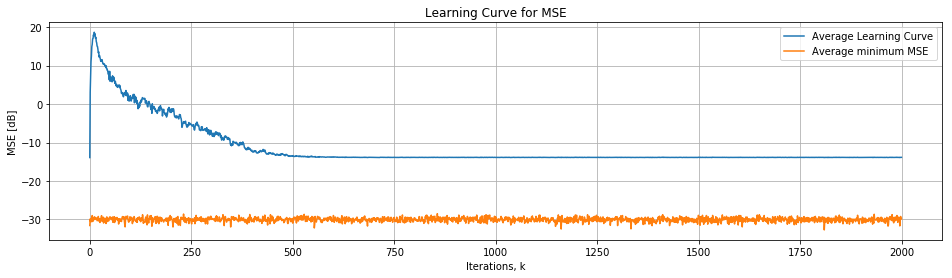

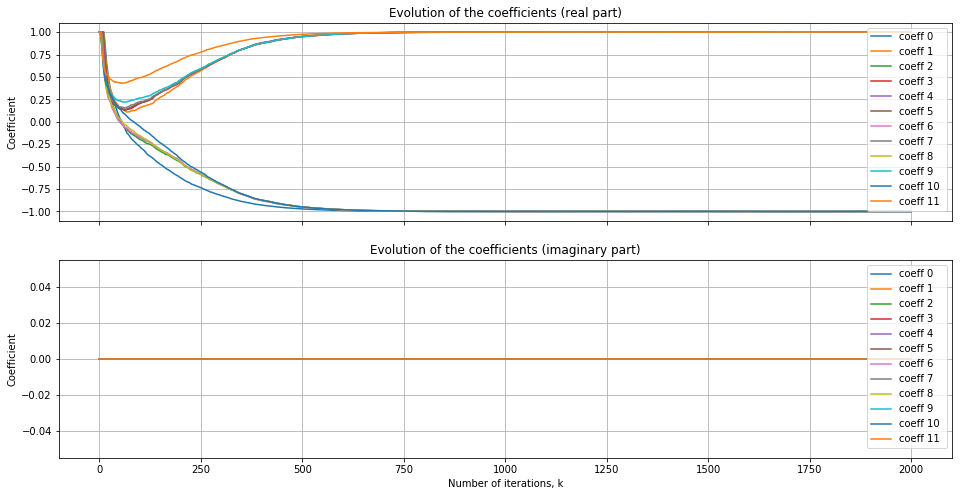

In [11]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 2000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

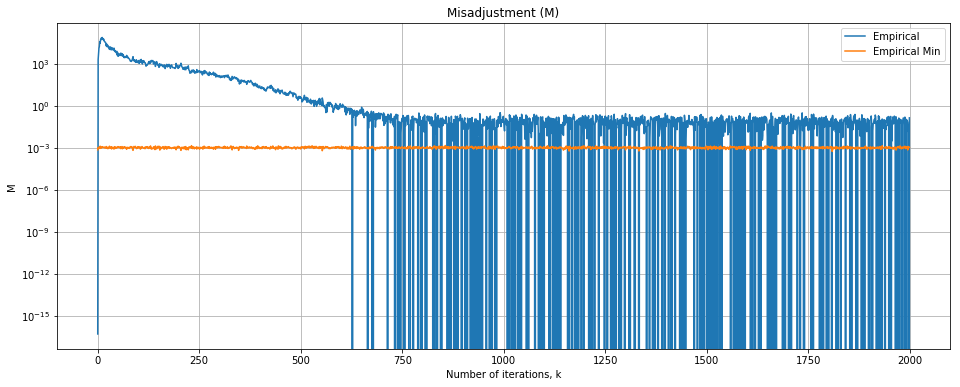

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment.jpg', bbox_inches = 'tight')

### (b) 

/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


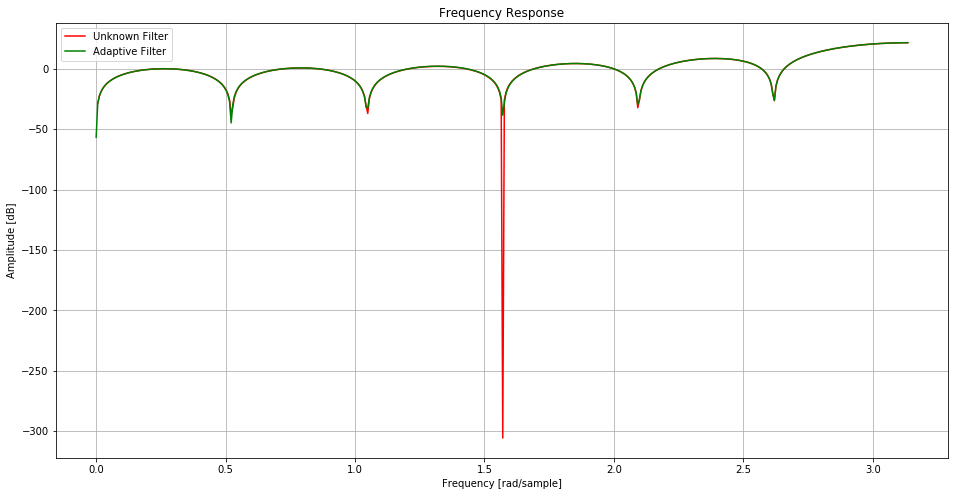

In [16]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response.jpg', bbox_inches = 'tight')

## Problem 23

For the NLMS algorithm, 

$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} = 0.03167$$

In [18]:
output_filepath = './Outputs/Chap_4/Exercise_23/'
model_name = 'NLMS'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)

Trace: 31.57894736842106
mu_max:  0.03166666666666666


### (b)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.5 µs


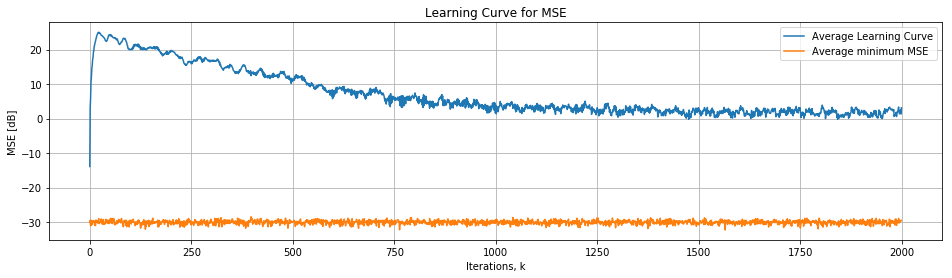

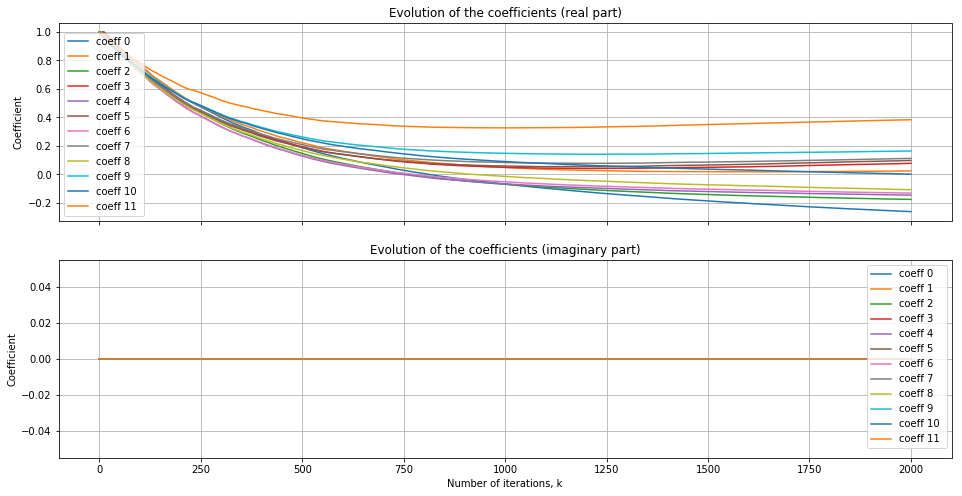

In [25]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 2000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 5
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

### (c)

mu_max/5: M_theoretical = 7.92665459521202


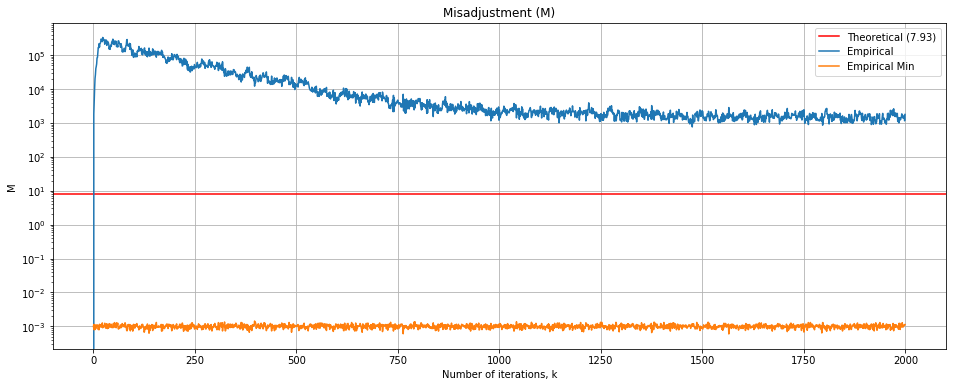

In [26]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(factor)+'.jpg', bbox_inches = 'tight')

### (d)

/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


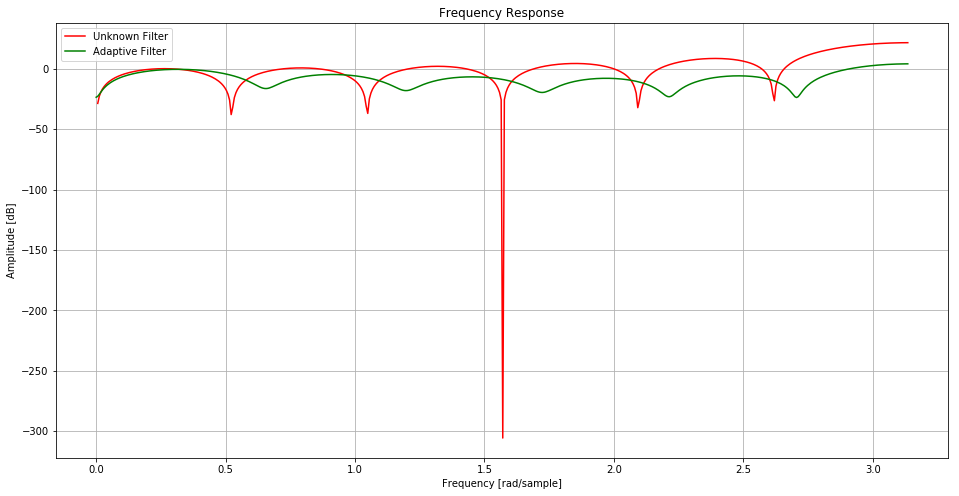

In [28]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(factor), bbox_inches = 'tight')